joel

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, accuracy_score

# Step 1: Load Dataset from UCI Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data = pd.read_csv(url, names=columns, header=None)

# Step 2: Split Features and Target
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Step 3: Data Preprocessing
def preprocess_car_evaluation(X, y):
    # Encode categorical features and target variable
    X_encoded = pd.get_dummies(X)  # One-hot encoding for features
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)  # Encode target
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    
    return X_scaled, y_encoded

X_preprocessed, y_preprocessed = preprocess_car_evaluation(X, y)

# Step 4: Unsupervised Learning - K-Means Clustering
def kmeans_clustering(X, y):
    kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
    y_pred = kmeans.fit_predict(X)
    ari = adjusted_rand_score(y, y_pred)  # Evaluate clustering performance
    return ari

kmeans_accuracy = kmeans_clustering(X_preprocessed, y_preprocessed)

# Step 5: Supervised Learning - Logistic Regression
def logistic_regression(X, y):
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train logistic regression model
    clf = LogisticRegression(random_state=42, max_iter=500)
    clf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

logistic_accuracy = logistic_regression(X_preprocessed, y_preprocessed)

# Display Results
print("K-Means Clustering (Unsupervised) Accuracy (ARI):", kmeans_accuracy)
print("Logistic Regression (Supervised) Accuracy:", logistic_accuracy)


K-Means Clustering (Unsupervised) Accuracy (ARI): 0.000729652868196255
Logistic Regression (Supervised) Accuracy: 0.928709055876686


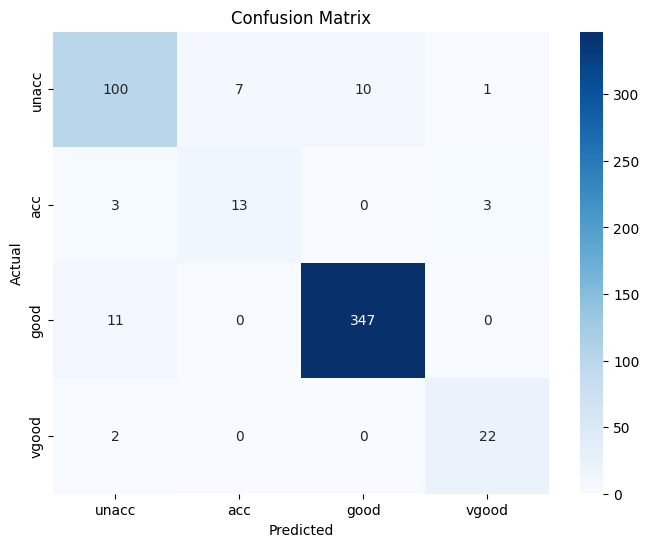

K-Means Clustering (Unsupervised) Accuracy (ARI): 0.000729652868196255
K-Means Clustering Silhouette Score: 0.13090261027176128
Logistic Regression (Supervised) Accuracy: 0.928709055876686
Classification Report (Logistic Regression):
              precision    recall  f1-score     support
unacc          0.862069  0.847458  0.854701  118.000000
acc            0.650000  0.684211  0.666667   19.000000
good           0.971989  0.969274  0.970629  358.000000
vgood          0.846154  0.916667  0.880000   24.000000
accuracy       0.928709  0.928709  0.928709    0.928709
macro avg      0.832553  0.854402  0.842999  519.000000
weighted avg   0.929391  0.928709  0.928953  519.000000


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    adjusted_rand_score, accuracy_score, confusion_matrix, classification_report, silhouette_score
)
from sklearn.decomposition import PCA

# Step 1: Load Dataset from UCI Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data = pd.read_csv(url, names=columns, header=None)

# Step 2: Split Features and Target
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Mapping class descriptions
class_mapping = {
    0: 'unacc',  # Unacceptable
    1: 'acc',    # Acceptable
    2: 'good',   # Good
    3: 'vgood'   # Very Good
}

# Step 3: Data Preprocessing
def preprocess_car_evaluation(X, y):
    # Encode categorical features and target variable
    X_encoded = pd.get_dummies(X)  # One-hot encoding for features
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)  # Encode target
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    
    return X_scaled, y_encoded

X_preprocessed, y_preprocessed = preprocess_car_evaluation(X, y)

# Step 4: Unsupervised Learning - K-Means Clustering
def kmeans_clustering(X, y):
    kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
    y_pred = kmeans.fit_predict(X)
    
    # Evaluate clustering performance
    ari = adjusted_rand_score(y, y_pred)
    silhouette = silhouette_score(X, y_pred)
    
    return kmeans, y_pred, ari, silhouette

kmeans, kmeans_labels, kmeans_ari, kmeans_silhouette = kmeans_clustering(X_preprocessed, y_preprocessed)


# Step 5: Supervised Learning - Logistic Regression
def logistic_regression(X, y):
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train logistic regression model
    clf = LogisticRegression(random_state=42, max_iter=500)
    clf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, target_names=list(class_mapping.values()))
    confusion = confusion_matrix(y_test, y_pred)
    
    return clf, acc, report, confusion

clf, logistic_accuracy, logistic_report, logistic_confusion = logistic_regression(X_preprocessed, y_preprocessed)

# Step 6: Visualize Confusion Matrix
def plot_confusion_matrix(confusion, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(logistic_confusion, list(class_mapping.values()))

# Display Results
print(f"K-Means Clustering (Unsupervised) Accuracy (ARI): {kmeans_ari}")
print(f"K-Means Clustering Silhouette Score: {kmeans_silhouette}")
print(f"Logistic Regression (Supervised) Accuracy: {logistic_accuracy}")
print("Classification Report (Logistic Regression):")
print(pd.DataFrame(logistic_report).transpose())


The Car Evaluation dataset was analyzed using both unsupervised and supervised learning methods. The unsupervised learning model, K-Means Clustering, produced an Adjusted Rand Index (ARI) of **0.0007** and a Silhouette Score of **0.13**. These results indicate that the clusters formed by K-Means do not align well with the true class labels, and the clustering quality is poor. This is likely due to the categorical nature of the dataset and the limitations of using Euclidean distance in K-Means after one-hot encoding. The dataset does not exhibit natural clusters, making K-Means unsuitable for this task.

In contrast, the supervised learning model, Logistic Regression, achieved an overall accuracy of **92.87%**, demonstrating strong performance. The model effectively classified the majority classes (good and unacc), achieving high precision and recall for these categories. The minority classes (acc and vgood) were more challenging to classify, with lower precision and recall due to their smaller sample sizes and potential feature overlap. For example, the acc class achieved a precision of **65%** and a recall of **68.4%**, reflecting some misclassification issues. Despite this, the model maintained a balanced performance across all classes, as evidenced by a macro F1-score of **84.3%** and a weighted F1-score of **92.9%**.

Overall, Logistic Regression significantly outperformed K-Means Clustering for this dataset, demonstrating that the structured and categorical nature of the data is better suited to supervised learning methods. Addressing class imbalance or exploring clustering algorithms tailored for categorical data, such as K-Prototypes, could further improve performance.